# Object-based colocalization analysis


<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../notebooks/08_colocalization/object_based_colocalization.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/08_colocalization/object_based_colocalization.ipynb" target="_blank">
        <img class="button-icon" src="../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [11]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "locan",
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "shapely",
#     "tifffile",
# ]
# ///

# Description
In this Notebook, we learn about point-based colocalization analysis 

## Objectives
Learn about mean nearest neighbor, the nearest neighbor function, and Ripley's K function.  
Learn Monte Carlo based validation. 

## Table of Contents
0. Load the data
1. Plot the data
2. Mean nearest neighbor distance
3. Nearest neighbor function
4. Ripley's K - with and without boundary correction
6. Validation - the null distribution
7. Validation - Monte Carlo based null hypothesis testing

In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from rich import print
from scipy.spatial import distance_matrix
from shapely.geometry import Point, box

## 0. Load the data

In [13]:
base = Path("../../_static/images/coloc/obj_based/")

fall_med_iac = np.loadtxt(base / "p_400_c1.csv", delimiter=",")
fall_med_bob = np.loadtxt(base / "p_400_c2.csv", delimiter=",")
fall_cold_iac = np.loadtxt(base / "g_p_400_dual_1.csv", delimiter=",")
fall_cold_bob = np.loadtxt(base / "g_p_400_dual_2.csv", delimiter=",")
fall_warm_iac = np.loadtxt(base / "p_400_c1_rep.csv", delimiter=",")
fall_warm_bob = np.loadtxt(base / "p_400_c2_rep.csv", delimiter=",")
winter_warm_iac = np.loadtxt(base / "g_p_400_c1.csv", delimiter=",")
winter_warm_bob = np.loadtxt(base / "g_p_400_c2.csv", delimiter=",")
winter_medium_iac = np.loadtxt(base / "g_p_as_c1.csv", delimiter=",")
winter_medium_bob = np.loadtxt(base / "g_p_as_c2.csv", delimiter=",")
winter_cold_iac = np.loadtxt(base / "g_p_400_c1_cor.csv", delimiter=",")
winter_cold_bob = np.loadtxt(base / "g_p_400_c2_cor.csv", delimiter=",")

## 1. Plot the data

In [14]:
def plotloc_2c(
    points_iac: np.ndarray,
    points_bob: np.ndarray,
    title: str,
    s: float = 15,
    ch1: str = "IAC",
    ch2: str = "BOB",
) -> None:
    """
    Plot two channels in a 2D space.
    Parameters:
    points_iac (np.ndarray): Points for channel 1.
    points_bob (np.ndarray): Points for channel 2.
    """
    plt.scatter(points_iac[:, 0], points_iac[:, 1], c="blue", label=ch1, s=s, alpha=1)
    plt.scatter(
        points_bob[:, 0],
        points_bob[:, 1],
        c="magenta",
        label=ch2,
        s=s,
        alpha=0.75,
        marker="s",
    )
    plt.title(label=title)
    plt.legend()

    plt.xlabel("x [au]")
    plt.ylabel("y [au]")
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

(400, 2)
(400, 2)

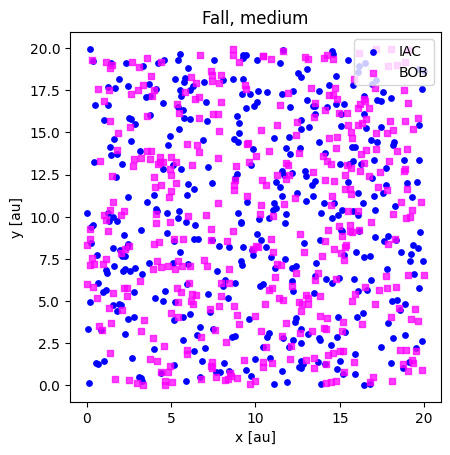

In [15]:
print(fall_med_iac.shape, fall_med_bob.shape)
plotloc_2c(fall_med_iac, fall_med_bob, title="Fall, medium")

(400, 2)
(400, 2)

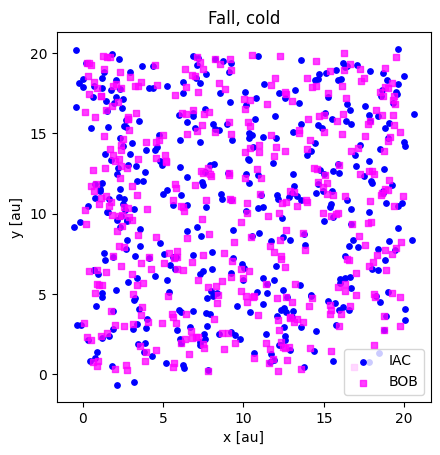

In [16]:
print(fall_cold_iac.shape, fall_cold_bob.shape)
plotloc_2c(fall_cold_iac, fall_cold_bob, title="Fall, cold")

(400, 2)
(400, 2)

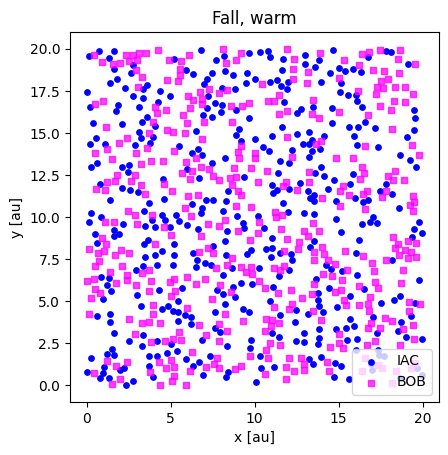

In [17]:
print(fall_warm_iac.shape, fall_warm_bob.shape)
plotloc_2c(fall_warm_iac, fall_warm_bob, title="Fall, warm")

(400, 2)
(400, 2)

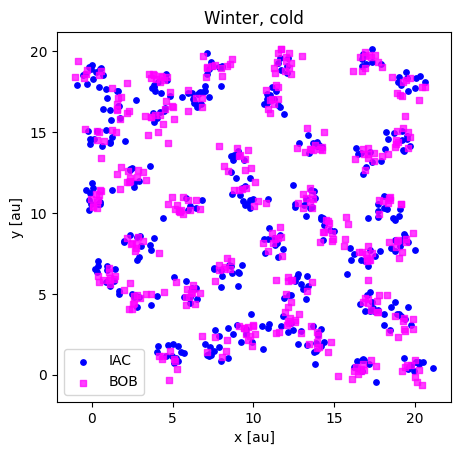

In [18]:
print(winter_cold_iac.shape, winter_cold_bob.shape)
plotloc_2c(winter_cold_iac, winter_cold_bob, title="Winter, cold")

(400, 2)
(200, 2)

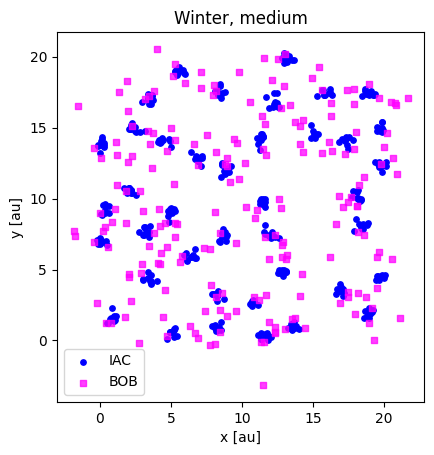

In [19]:
print(winter_medium_iac.shape, winter_medium_bob.shape)
plotloc_2c(winter_medium_iac, winter_medium_bob, title="Winter, medium")

(400, 2)
(400, 2)

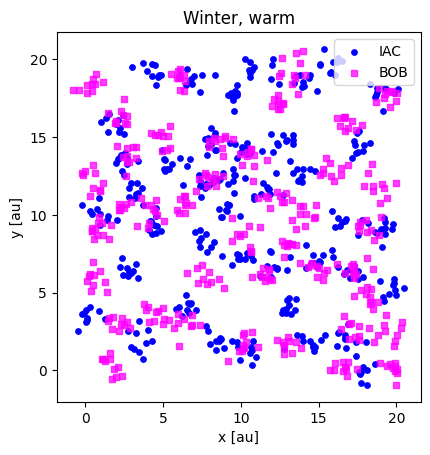

In [20]:
print(winter_warm_iac.shape, winter_warm_bob.shape)
plotloc_2c(winter_warm_iac, winter_warm_bob, title="Winter, warm")

## 2. Mean nearest neighbor distance

### ✍️ Exercise: Code along

In [21]:
def meanNN(points1: np.ndarray, points2: np.ndarray) -> tuple[np.ndarray, float]:
    """
    Computes the mean nearest neighbor distances for a set of 2D points.
    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points; if None, uses points1

    Returns:
    - min_dists: array of minimum distances of each point in points1 to its nearest neighbor in points2
    - mean_nn: mean of the minimum distances
    """

    d12 = distance_matrix(points1, points2)

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(d12, np.inf)

    min_dists = np.min(d12, axis=1)
    mean_nn = np.mean(min_dists)

    return min_dists, mean_nn

### Compute Fall samples

In [22]:
nndist_fall_med, meannn_fall_med = meanNN(fall_med_iac, fall_med_bob)
nndist_fall_cold, meannn_fall_cold = meanNN(fall_cold_iac, fall_cold_bob)
nndist_fall_warm, meannn_fall_warm = meanNN(fall_warm_iac, fall_warm_bob)


# nndist_fall_med, meannn_fall_med = meanNN(fall_med_bob, fall_med_iac, )
# nndist_fall_cold, meannn_fall_cold = meanNN(fall_cold_bob, fall_cold_iac)
# nndist_fall_warm, meannn_fall_warm = meanNN(fall_warm_bob, fall_warm_iac)

### Plot Fall samples

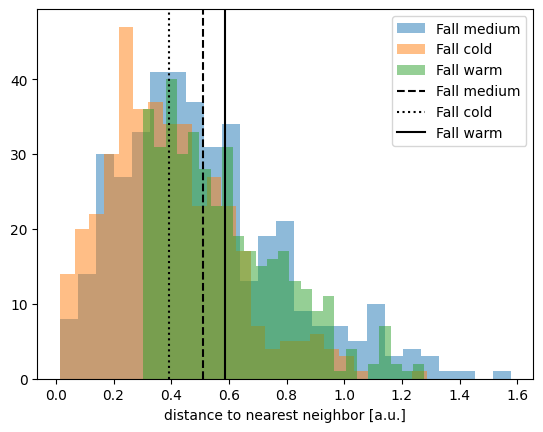

In [23]:
plt.hist(nndist_fall_med, label="Fall medium", alpha=0.5, bins=25)
plt.hist(nndist_fall_cold, label="Fall cold", alpha=0.5, bins=25)
plt.hist(nndist_fall_warm, label="Fall warm", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbor [a.u.]")
plt.axvline(meannn_fall_med, c="k", linestyle="--", label="Fall medium")
plt.axvline(meannn_fall_cold, c="k", linestyle=":", label="Fall cold")
plt.axvline(meannn_fall_warm, c="k", linestyle="-", label="Fall warm")
plt.legend()

### Compute Winter samples

In [24]:
nndist_winter_warm, meannn_winter_warm = meanNN(winter_warm_iac, winter_warm_bob)
nndist_winter_medium, meannn_winter_medium = meanNN(
    winter_medium_iac, winter_medium_bob
)
nndist_winter_cold, meannn_winter_cold = meanNN(winter_cold_iac, winter_cold_bob)

### Plot Winter samples

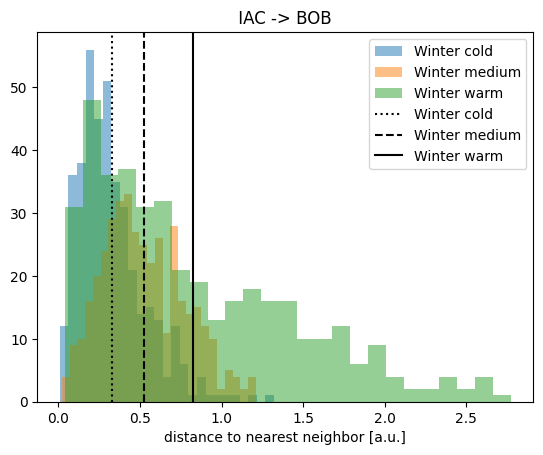

In [25]:
plt.hist(nndist_winter_cold, label="Winter cold", alpha=0.5, bins=25)
plt.hist(nndist_winter_medium, label="Winter medium", alpha=0.5, bins=25)
plt.hist(nndist_winter_warm, label="Winter warm", alpha=0.5, bins=25)

plt.xlabel("distance to nearest neighbor [a.u.]")
plt.title(" IAC -> BOB ")
plt.axvline(meannn_winter_cold, c="k", linestyle=":", label="Winter cold")
plt.axvline(meannn_winter_medium, c="k", linestyle="--", label="Winter medium")
plt.axvline(meannn_winter_warm, c="k", linestyle="-", label="Winter warm")
plt.legend()

### ✍️ Exercise: Change the order of points provided to ```meanNN()``` for the winter samples
E.g. switch the order in which ```winter_warm_iac``` and ```winter_warm_bob``` is passed to ```meanNN()```.   
Do the same for ```winter_cold_iac``` and ```winter_cold_bob```, as well as ```winter_medium_iac``` and ```winter_medium_bob```. 

In [72]:
nndist_winter_warm_2, meannn_winter_warm_2 = ..., ...
nndist_winter_medium_2, meannn_winter_medium_2 = ..., ...
nndist_winter_cold_2, meannn_winter_cold_2 = ..., ...

In [ ]:
nndist_winter_warm_2, meannn_winter_warm_2 = meanNN(winter_warm_bob, winter_warm_iac)
nndist_winter_medium_2, meannn_winter_medium_2 = meanNN(
    winter_medium_bob, winter_medium_iac
)
nndist_winter_cold_2, meannn_winter_cold_2 = meanNN(winter_cold_bob, winter_cold_iac)

### Plot the results

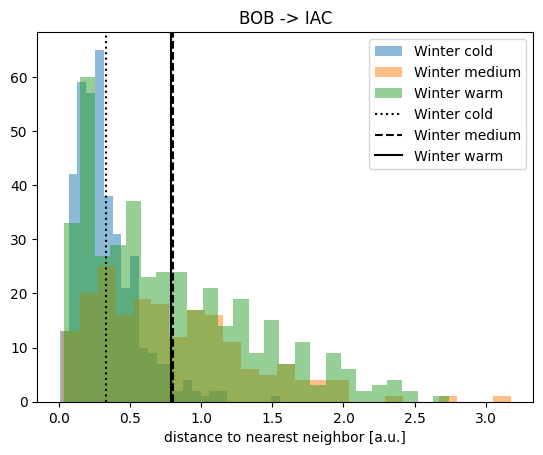

In [27]:
plt.hist(nndist_winter_cold_2, label="Winter cold", alpha=0.5, bins=25)
plt.hist(nndist_winter_medium_2, label="Winter medium", alpha=0.5, bins=25)
plt.hist(nndist_winter_warm_2, label="Winter warm", alpha=0.5, bins=25)

plt.title("BOB -> IAC")
plt.xlabel("distance to nearest neighbor [a.u.]")
plt.axvline(meannn_winter_cold_2, c="k", linestyle=":", label="Winter cold")
plt.axvline(meannn_winter_medium_2, c="k", linestyle="--", label="Winter medium")
plt.axvline(meannn_winter_warm_2, c="k", linestyle="-", label="Winter warm")
plt.legend()

## 3. Nearest neighbor function

In [28]:
def nearest_neighbor_function(
    points1: np.ndarray, points2: np.ndarray, radii: np.ndarray
) -> np.ndarray:
    """
    Computes the nearest neighbor function for a set of 2D points.

    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points
    - radii: array-like of radii at which to evaluate the nearest neighbor function
    Returns:
    - S: array of nearest neighbor function values at each radius
    - mu0: array of expected values under the null model at each radius
    """

    # calculate area based on bounding box of all points
    allpoints = np.vstack((points1, points2))
    max_x, max_y = np.max(allpoints, axis=0)
    min_x, min_y = np.min(allpoints, axis=0)
    (max_x - min_x) * (max_y - min_y)

    n1 = len(points1)  # number of points in the first set
    d12 = distance_matrix(points1, points2)

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(
            d12, np.inf
        )  # Set diagonal to infinity to ignore self-distances

    min_dists = np.min(d12, axis=1)  # nearest neighbor distances per point

    S = np.empty(radii.shape, dtype=float)

    for i, r in enumerate(radii):
        within_r = min_dists < r
        n_within_r = len(min_dists[within_r])
        S[i] = n_within_r / n1

    return S

In [29]:
def plot_nn_function(
    s: np.ndarray,
    radii: np.ndarray,
    nulldist: np.ndarray = None,
    show: bool = True,
    label: str = "observed",
    line: str = "-",
) -> None:
    """Plots the nearest neighbor function S(r) with optional null model mean.
    Parameters:
    - s: array of S(r) values
    - radii: array of radii at which S(r) is evaluated
    - nulldist: optional array of null model mean values; if provided, plotted in red
    - show: if True, displays the plot; if False, only prepares the plot
    - label: label for the S(r) line in the plot
    - line: line style for the S(r) plot; default is solid line
    """
    if nulldist is not None:
        plt.plot(radii, nulldist, c="red", alpha=0.5, label="null‐model mean")

    plt.plot(radii, s, c="black", alpha=0.8, label=f"{label}", linestyle=line)

    plt.legend()
    plt.xlabel("r")
    plt.ylabel("S(r)")
    plt.tight_layout()
    if show:
        plt.show()

### Define radii for which to evaluate the nearest neighbor function

In [ ]:
radii = np.arange(0, 3, 0.1)

#### Inspect the fall samples

In [31]:
s_fall_med = nearest_neighbor_function(fall_med_iac, fall_med_bob, radii)
s_fall_warm = nearest_neighbor_function(fall_warm_iac, fall_warm_bob, radii)
s_fall_cold = nearest_neighbor_function(fall_cold_iac, fall_cold_bob, radii)

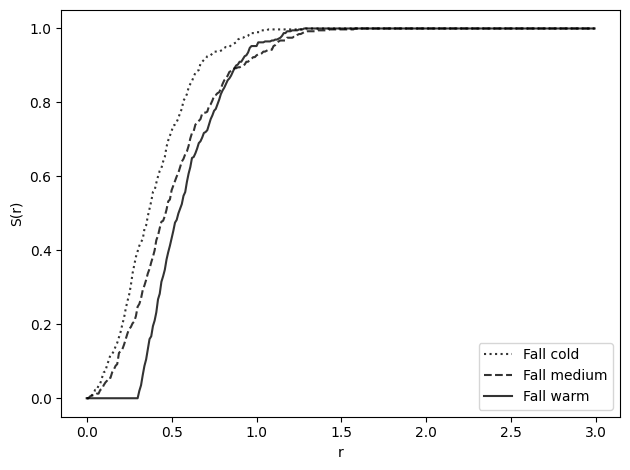

In [32]:
plot_nn_function(s_fall_cold, radii, show=False, label="Fall cold", line=":")
plot_nn_function(s_fall_med, radii, show=False, label="Fall medium", line="--")
plot_nn_function(s_fall_warm, radii, show=False, label="Fall warm", line="-")

#### Inspect the winter samples

In [33]:
s_winter_warm = nearest_neighbor_function(winter_warm_iac, winter_warm_bob, radii)
s_winter_medium = nearest_neighbor_function(winter_medium_iac, winter_medium_bob, radii)
s_winter_cold = nearest_neighbor_function(winter_cold_iac, winter_cold_bob, radii)
s_winter_warm_2 = nearest_neighbor_function(winter_warm_bob, winter_warm_iac, radii)
s_winter_medium_2 = nearest_neighbor_function(
    winter_medium_bob, winter_medium_iac, radii
)
s_winter_cold_2 = nearest_neighbor_function(winter_cold_bob, winter_cold_iac, radii)

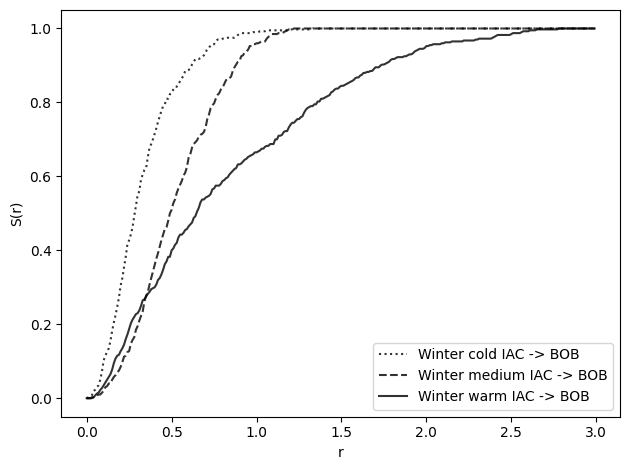

In [34]:
plot_nn_function(
    s_winter_cold, radii, show=False, label="Winter cold IAC -> BOB", line=":"
)
plot_nn_function(
    s_winter_medium, radii, show=False, label="Winter medium IAC -> BOB", line="--"
)
plot_nn_function(
    s_winter_warm, radii, show=False, label="Winter warm IAC -> BOB", line="-"
)

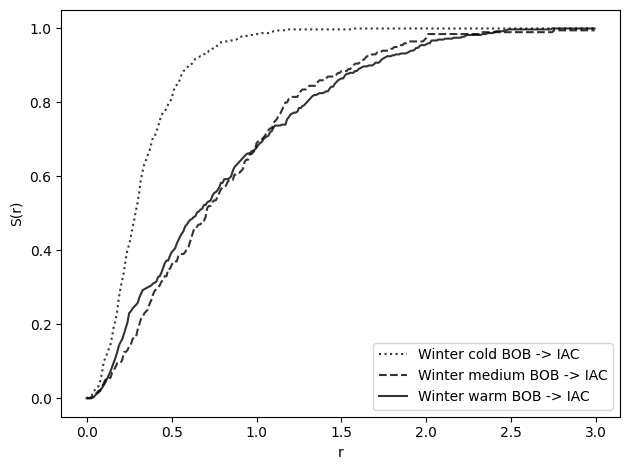

In [35]:
plot_nn_function(
    s_winter_cold_2, radii, show=False, label="Winter cold BOB -> IAC", line=":"
)
plot_nn_function(
    s_winter_medium_2, radii, show=False, label="Winter medium BOB -> IAC", line="--"
)
plot_nn_function(
    s_winter_warm_2, radii, show=False, label="Winter warm BOB -> IAC", line="-"
)

## 4. Ripley's K function

In [36]:
def ripleys_k_function(
    points1: np.ndarray,
    points2: np.ndarray,
    radii: np.ndarray,
    area=None,
    edge_correction=False,
) -> np.ndarray:
    """
    Computes Ripley's K function for a set of 2D points.

    Parameters:
    - points1: array of shape (n_points, 2) representing the coordinates of the first set of points
    - points2: array of shape (n_points, 2) representing the coordinates of the second set of points
    - radii: array-like of radii at which to evaluate K
    - area: total area of the observation window; if None, calculated from bounding box
    - edge_correction: if True, applies basic border edge correction

    Returns:
    - ks: K-function values at each radius
    """

    #### Get the number of points
    n1 = len(points1)
    n2 = len(points2)
    ks = np.zeros_like(radii, dtype=float)
    dists = distance_matrix(points1, points2)

    #### Compute area if not provided
    allpoints = np.vstack((points1, points2))
    max_x, max_y = np.max(allpoints, axis=0)

    if area is None:
        min_x, min_y = np.min(allpoints, axis=0)
        area = (max_x - min_x) * (max_y - min_y)
    else:
        min_x = 0
        min_y = 0
        max_x = np.max([max_x, np.sqrt(area)])
        max_y = np.max([max_y, np.sqrt(area)])

    if edge_correction:
        # Determine FOV area
        square = box(min_x, min_y, max_x, max_y)
        area_correction = np.zeros_like(dists)

        for i in range(n1):
            for j in range(n2):
                circle = Point(points1[i]).buffer(dists[i][j])
                if circle.area == 0 or circle.intersection(square).area == 0:
                    continue  # Avoid division by zero
                area_correction[i][j] = circle.area / circle.intersection(square).area

    if points1 is points2 or np.shares_memory(points1, points2):
        np.fill_diagonal(dists, np.inf)

    for i, r in enumerate(radii):
        within_r = dists < r

        if edge_correction:
            within_r = within_r * area_correction

        count_within_r = np.sum(within_r)

        ks[i] = (area / (n1 * n2)) * count_within_r

    return ks

### Define radii for which to compute Ripley's K function

### ✍️ Exercise: Think: Should these be the same maximum radius as provided to the nearest neighbor function? 
If yes, why?  
If no, why not?  

In [73]:
k_radii = np.arange(0, 2.01, 0.5)  # radii for which to compute the K-function

#### Compute K for the fall samples

In [38]:
k_fall_med = ripleys_k_function(fall_med_iac, fall_med_bob, radii=k_radii, area=400)
k_fall_cold = ripleys_k_function(fall_cold_iac, fall_cold_bob, radii=k_radii, area=400)
k_fall_warm = ripleys_k_function(fall_warm_iac, fall_warm_bob, radii=k_radii, area=400)

#### Compute K for the winter samples

In [39]:
k_winter_warm = ripleys_k_function(
    winter_warm_iac, winter_warm_bob, radii=k_radii, area=400
)
k_winter_medium = ripleys_k_function(
    winter_medium_iac, winter_medium_bob, radii=k_radii, area=400
)
k_winter_cold = ripleys_k_function(
    winter_cold_iac, winter_cold_bob, radii=k_radii, area=400
)

#### Here, we change the order to BOB -> IAC for ```k_winter_medium```

In [40]:
k_winter_medium_2 = ripleys_k_function(
    winter_medium_bob, winter_medium_iac, radii=k_radii, area=400
)

print(k_winter_medium_2 == k_winter_medium)

[ True  True  True  True  True  True  True  True  True  True  True]

#### Inspect the results

In [41]:
def plot_ripleys_k(
    k: np.ndarray,
    radii: np.ndarray,
    label: str = "uniform",
    show: bool = True,
    line: str = "-",
) -> None:
    """
    Plots Ripley's K function.
    Parameters:
    - k: array of K function values
    - radii: array of radii at which K is evaluated
    - label: label for the plot
    - show: whether to show the plot
    - line: line style for the plot
    """
    plt.plot(radii, k, color="k", label=f"{label}, no edge correction", linestyle=line)
    plt.xlabel("r")
    plt.ylabel("K(r)")
    plt.legend()
    if show:
        plt.show()

#### Fall samples

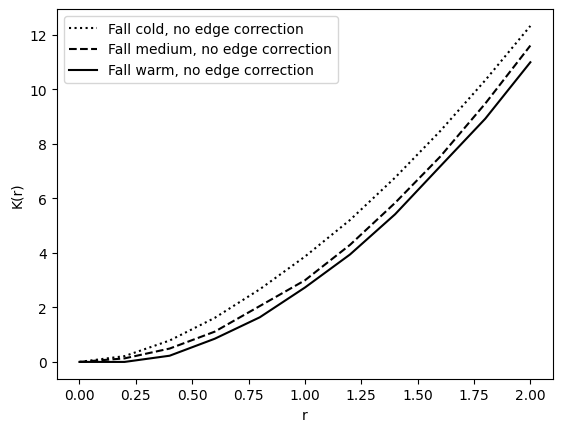

In [42]:
plot_ripleys_k(k_fall_cold, k_radii, label="Fall cold", show=False, line=":")
plot_ripleys_k(k_fall_med, k_radii, label="Fall medium", show=False, line="--")
plot_ripleys_k(k_fall_warm, k_radii, label="Fall warm", show=False, line="-")

#### Winter samples

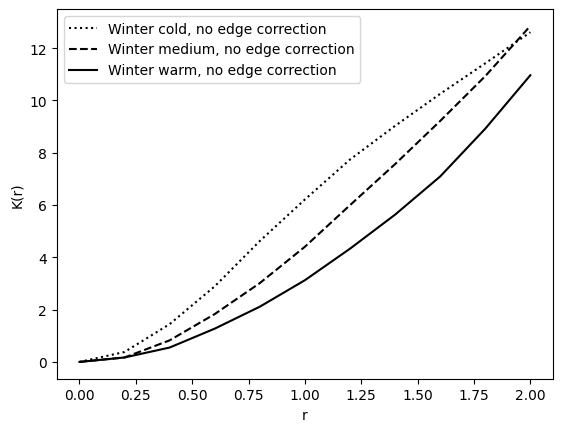

In [43]:
plot_ripleys_k(k_winter_cold, k_radii, label="Winter cold", line=":", show=False)
plot_ripleys_k(k_winter_medium, k_radii, label="Winter medium", line="--", show=False)
plot_ripleys_k(k_winter_warm, k_radii, label="Winter warm", show=False)

### 4.1 Ripley's K with edge correction

In [44]:
def plot_ripleys_k_ec(
    k: np.ndarray, k_corrected: np.ndarray, radii: np.ndarray, label: str = "uniform"
) -> None:
    """
    Plots Ripley's K function with and without edge correction.
    Parameters:
    - k: array of K function values without edge correction
    - k_corrected: array of K function values with edge correction
    - radii: array of radii at which K function is evaluated
    - label: label for the plot, default is "uniform"
    """
    plt.plot(
        radii,
        k,
        color="k",
        label=f"{label}, no edge correction",
        linestyle="-",
        alpha=0.5,
    )
    plt.plot(
        radii,
        k_corrected,
        color="k",
        label=f"{label}, edge correction",
        linestyle="-.",
    )
    plt.title("Ripley's K function")
    plt.legend()
    plt.xlabel("r")
    plt.ylabel("K(r)")
    # plt.show()

#### Compute the fall samples

In [45]:
k_fall_med_ec = ripleys_k_function(
    fall_med_iac, fall_med_bob, radii=k_radii, area=400, edge_correction=True
)
k_fall_warm_ec = ripleys_k_function(
    fall_warm_iac, fall_warm_bob, radii=k_radii, area=400, edge_correction=True
)

k_fall_cold_ec = ripleys_k_function(
    fall_cold_iac, fall_cold_bob, radii=k_radii, area=400, edge_correction=True
)

#### Compute the winter samples

In [46]:
k_winter_warm_ec = ripleys_k_function(
    winter_warm_iac, winter_warm_bob, radii=k_radii, area=400, edge_correction=True
)

k_winter_medium_ec = ripleys_k_function(
    winter_medium_iac, winter_medium_bob, radii=k_radii, area=400, edge_correction=True
)

k_winter_cold_ec = ripleys_k_function(
    winter_cold_iac, winter_cold_bob, radii=k_radii, area=400, edge_correction=True
)

#### Plot a fall sample with edge correction

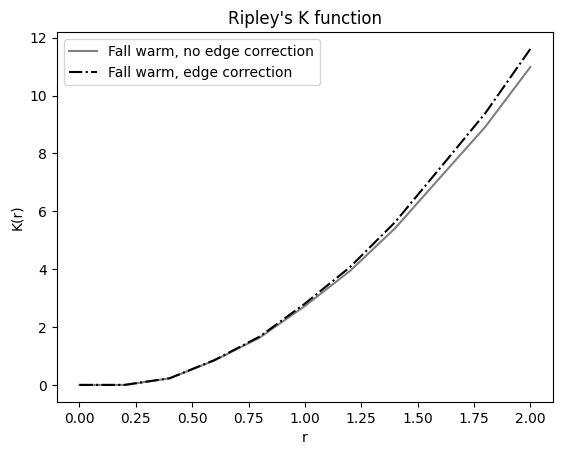

In [47]:
plot_ripleys_k_ec(k_fall_warm, k_fall_warm_ec, k_radii, label="Fall warm")

#### Plot a winter sample with edge correction

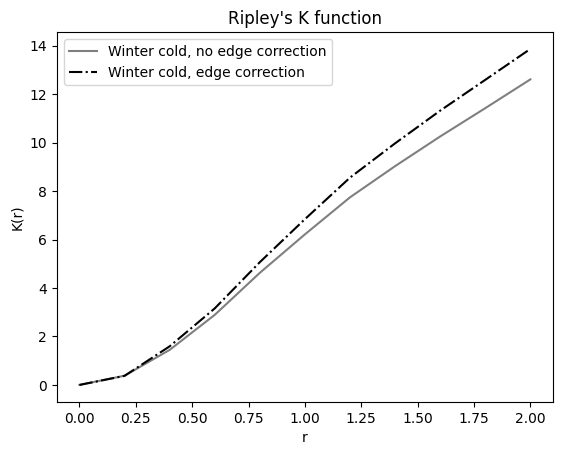

In [48]:
plot_ripleys_k_ec(k_winter_cold, k_winter_cold_ec, k_radii, label="Winter cold")

***

## 5. Validations - the null distribution

### Calculate the null distribution of the nearest neighbor function

In [49]:
def getnulldist(n: int, radii: np.ndarray, area: float) -> np.ndarray:
    """
    Computes the expected nearest neighbor distances under a null model for a set of 2D points.
    Parameters:
    - points2: array of shape (n_points, 2) representing the coordinates of the points to compute nearest n
    neighbor distances to
    - radii: array-like of radii at which to evaluate the null model

    Returns:
    - mu0: array of expected nearest neighbor distances at each radius
    """

    mu0 = np.empty(radii.shape, dtype=float)

    for i, r in enumerate(radii):
        mu0[i] = 1 - np.exp(-(n / area) * np.pi * (r**2))

    return mu0

### ✍️ Exercise: Try different values for ```n``` and ```area``` 
You can plot the cell directly below to inspect the effect on ```nulldist```.  
Try out different values.  
Think what would be the correct values for the **fall samples**!

In [69]:
n = 1345345  # number of points in the dataset
area = 4056780  # area of the FOV

nulldist = getnulldist(
    n=n, area=area, radii=radii
)  # These are not good values for n and area. Change them!

#### Plot the fall samples

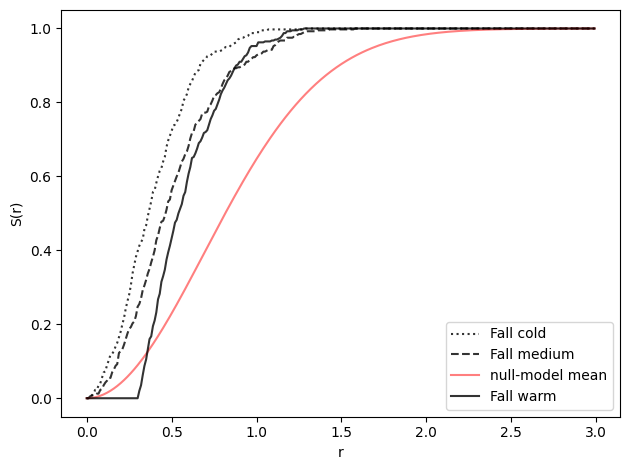

In [70]:
plot_nn_function(s_fall_cold, radii, show=False, label="Fall cold", line=":")
plot_nn_function(s_fall_med, radii, show=False, label="Fall medium", line="--")
plot_nn_function(
    s_fall_warm, radii, show=False, label="Fall warm", line="-", nulldist=nulldist
)

#### Plot the winter samples

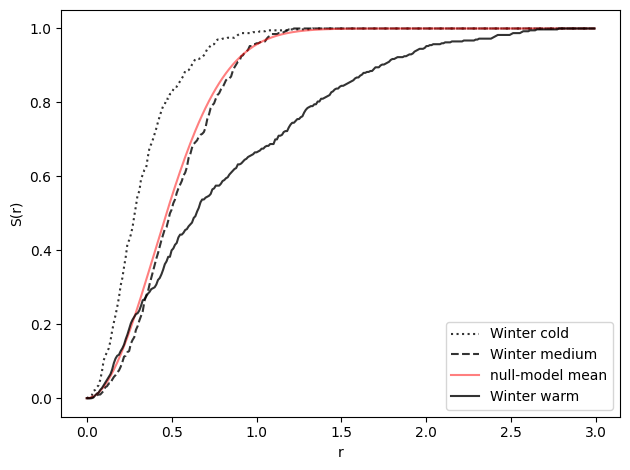

In [52]:
plot_nn_function(s_winter_cold, radii, show=False, label="Winter cold", line=":")
plot_nn_function(s_winter_medium, radii, show=False, label="Winter medium", line="--")
plot_nn_function(
    s_winter_warm, radii, show=True, label="Winter warm", nulldist=nulldist
)

## 6. Validation - Monte-Carlo based null-hypothesis testing

### ✍️ Exercise, code along: Blindly throw darts at a 20 x 20 cm board

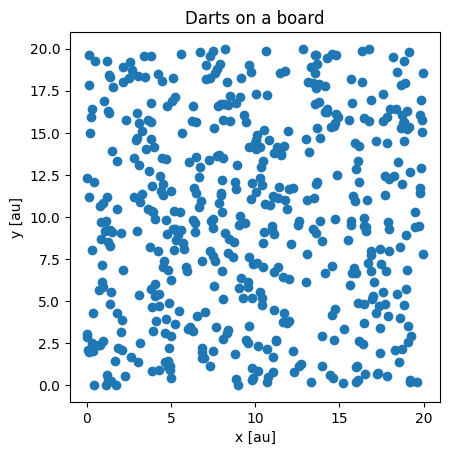

In [53]:
seed = 5
rng = np.random.default_rng(seed)
board_x = 20
board_y = 20
n_darts = 500
x = rng.uniform(0, board_x, size=n_darts)
y = rng.uniform(0, board_y, size=n_darts)

plt.scatter(x, y)
plt.xlabel("x [au]")
plt.ylabel("y [au]")
plt.title("Darts on a board")
plt.gca().set_aspect("equal")

### 6.1 Simulate under the null hypothesis

In [54]:
def sample_uniform_points_batch(
    ndraw: int, num_points: int = 400, x_max: int = 10, y_max: int = 10, seed: int = 42
) -> np.ndarray:
    """
    Generate *ndraw* independent batches of 2-D points drawn from independent
    **uniform random** distributions on the rectangle ``[0, x_max] × [0, y_max]``.

    Unlike a “uniform grid,” the points are *randomly* scattered—each position
    inside the rectangle has equal probability of being chosen.

    Parameters
    ----------
    ndraw : int
        Number of batches to generate.
    num_points : int
        Number of points in each batch.
    x_max : int
        Maximum x-coordinate value.
    y_max : int
        Maximum y-coordinate value.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    np.ndarray
        Array of shape (ndraw, num_points, 2) containing the generated points.
    """
    rng = np.random.default_rng(seed)

    x = rng.uniform(0, x_max, size=(ndraw, num_points, 1))
    y = rng.uniform(0, y_max, size=(ndraw, num_points, 1))

    return np.concatenate([x, y], axis=-1)

In [55]:
ndraw = 1000  # Sufficiently large for statistics.
num_points = len(fall_med_iac)  # Same number of points as our data
points_multiple = sample_uniform_points_batch(
    ndraw, num_points=num_points, x_max=20, y_max=20
)

#### Inspect the random results

In [56]:
def plotpoints(points: np.ndarray, title: str = "Monte carlo simulated points") -> None:
    """Plots a set of 2D points.
    Parameters:
    - points: array of shape (n_points, 2) representing the coordinates of the points
    - title: title of the plot

    """
    plt.scatter(points[:, 0], points[:, 1], c="k", s=10)
    plt.title(label=title)

    plt.xlabel("x [au]")
    plt.ylabel("y [au]")
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")

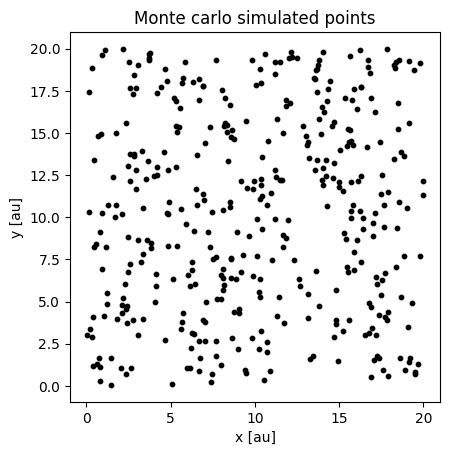

In [57]:
sample_i = 999
plotpoints(points_multiple[sample_i])

### 6.2 Validate - Mean nearest neighbor distance

#### Calculate the mean nearest neighbor distance for each random dataset 

In [58]:
nn_multiple = np.zeros(ndraw, dtype=float)
for i in range(ndraw):  # for all randomly generated samples
    _, mean_i = meanNN(points_multiple[i], points_multiple[i])  # calculate their mean
    nn_multiple[i] = mean_i

#### Define significance level for later testing

In [59]:
alpha = 5  # %
bound_low = alpha / 2
bound_upper = 100 - bound_low
percentile_low = np.percentile(nn_multiple, bound_low)
percentile_high = np.percentile(nn_multiple, bound_upper)

#### Fall samples

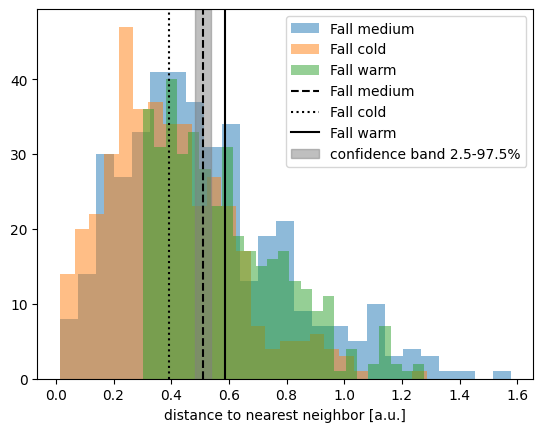

In [60]:
plt.hist(nndist_fall_med, label="Fall medium", alpha=0.5, bins=25)
plt.hist(nndist_fall_cold, label="Fall cold", alpha=0.5, bins=25)
plt.hist(nndist_fall_warm, label="Fall warm", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbor [a.u.]")
plt.axvline(meannn_fall_med, c="k", linestyle="--", label="Fall medium")
plt.axvline(meannn_fall_cold, c="k", linestyle=":", label="Fall cold")
plt.axvline(meannn_fall_warm, c="k", linestyle="-", label="Fall warm")

# Now we display the confidence bounds
plt.axvspan(
    percentile_low,
    percentile_high,
    color="gray",
    alpha=0.5,
    label=f"confidence band {bound_low}-{bound_upper}%",
)
plt.legend()

#### Winter samples

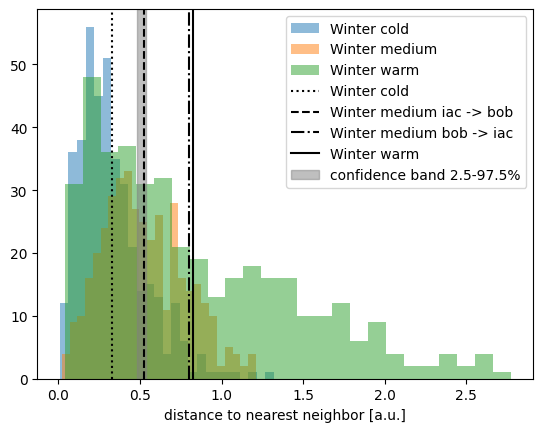

In [61]:
plt.hist(nndist_winter_cold, label="Winter cold", alpha=0.5, bins=25)
plt.hist(nndist_winter_medium, label="Winter medium", alpha=0.5, bins=25)
plt.hist(nndist_winter_warm, label="Winter warm", alpha=0.5, bins=25)
plt.xlabel("distance to nearest neighbor [a.u.]")
plt.axvline(meannn_winter_cold, c="k", linestyle=":", label="Winter cold")
plt.axvline(
    meannn_winter_medium, c="k", linestyle="--", label="Winter medium iac -> bob"
)
plt.axvline(
    meannn_winter_medium_2, c="k", linestyle="-.", label="Winter medium bob -> iac"
)
plt.axvline(meannn_winter_warm, c="k", linestyle="-", label="Winter warm")
plt.axvspan(
    percentile_low,
    percentile_high,
    color="gray",
    alpha=0.5,
    label=f"confidence band {bound_low}-{bound_upper}%",
)
plt.legend()

### 6.3 Validate - Nearest neighbor function

#### Plot confidence intervals for the nearest neighbor function: 

In [62]:
def plot_envelope(
    s: np.ndarray,
    s_multiple: np.ndarray,
    radii: np.ndarray,
    alpha: float = 5,
    label: str = "data",
    metric: str = "K(r)",
    show: bool = True,
    linestyle: str = "-",
):
    """
    Plots the envelope of a metric (e.g., Nearest neighbor function, or K-function) with confidence intervals.
    Parameters:
    - s: array of metric values for the observed data
    - s_multiple: array of metric values for multiple realizations (i.e. of monte Carlo simulations)
    - radii: array of radii at which the metric is evaluated
    - alpha: significance level for the confidence interval (default is 5)
    - label: label for the observed data in the plot
    - metric: name of the metric being plotted (default is "K(r)" for ripley's K function)
    - show: whether to show the plot (default is True).
    If False, the plot is not shown but can be saved or further processed.
    """
    if show:  # show confidence intervals
        ndraw = len(s_multiple)
        s_multiple_mean = np.mean(s_multiple, axis=0)
        bound_low = alpha / 2
        bound_upper = 100 - bound_low
        percentiles_low = np.percentile(s_multiple, bound_low, axis=0)
        percentiles_high = np.percentile(s_multiple, bound_upper, axis=0)

        plt.plot(  # plot the mean of the multiple realizations
            radii,
            s_multiple_mean,
            color="grey",
            label=f"mean of {ndraw} realizations",
            zorder=0,
        )

        plt.fill_between(  # fill the area between the percentiles
            radii,
            percentiles_low,
            percentiles_high,
            color="grey",
            alpha=0.3,
            label=f"{bound_low}-{bound_upper}% quantile range",
        )

    plt.plot(
        radii, s, label=label, color="k", linestyle=linestyle
    )  # plot the observed data
    plt.legend()
    plt.xlabel("r")
    plt.ylabel(f"{metric}")
    # if show:
    #     plt.show()

### Compute the nearest neighbor function for all random samples

In [63]:
s_multiple = np.zeros([ndraw, len(radii)], dtype=float)
for i in range(ndraw):
    s_multiple[i] = nearest_neighbor_function(
        points_multiple[i], points_multiple[i], radii
    )

#### Fall samples

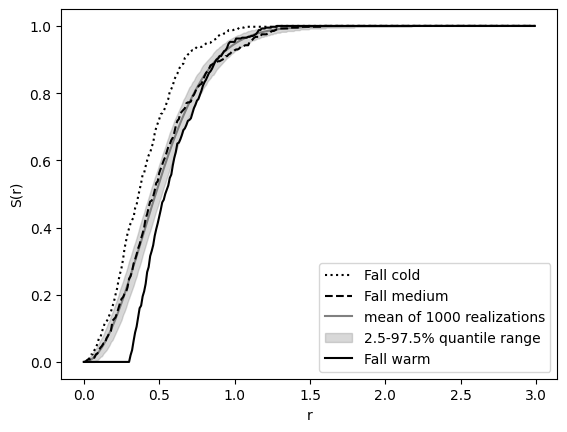

In [64]:
plot_envelope(
    s_fall_cold,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Fall cold",
    linestyle=":",
    show=False,
)
plot_envelope(
    s_fall_med,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Fall medium",
    linestyle="--",
    show=False,
)

plot_envelope(
    s_fall_warm,
    s_multiple,
    radii=radii,
    metric="S(r)",
    linestyle="-",
    label="Fall warm",
    show=True,
)

#### Winter samples

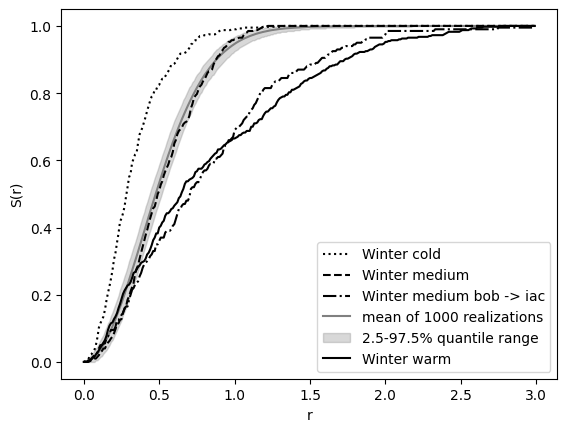

In [65]:
plot_envelope(
    s_winter_cold,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Winter cold",
    linestyle=":",
    show=False,
)

plot_envelope(
    s_winter_medium,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Winter medium",
    linestyle="--",
    show=False,
)

plot_envelope(
    s_winter_medium_2,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Winter medium bob -> iac",
    linestyle="-.",
    show=False,
)

plot_envelope(
    s_winter_warm,
    s_multiple,
    radii=radii,
    metric="S(r)",
    label="Winter warm",
    show=True,
)

### 6.4 Validate - Ripley's K

Here, we can reuse the sample plotting function as defined for the nearest neighbor function

#### Compute Ripley's K for all randomly generated samples

In [66]:
ks_multiple = np.zeros([ndraw, len(k_radii)], dtype=float)
for i in range(ndraw):
    ks_multiple[i] = ripleys_k_function(
        points_multiple[i],
        points_multiple[i],
        radii=k_radii,
        area=400,
        edge_correction=False,
    )

#### Fall samples

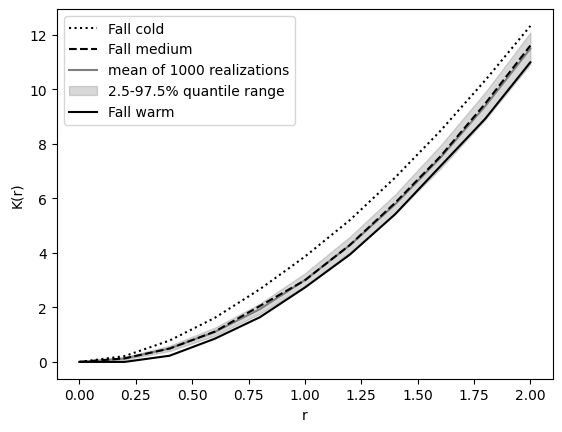

In [67]:
plot_envelope(
    k_fall_cold,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Fall cold",
    show=False,
    linestyle=":",
)
plot_envelope(
    k_fall_med,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Fall medium",
    linestyle="--",
    show=False,
)

plot_envelope(
    k_fall_warm, ks_multiple, radii=k_radii, metric="K(r)", label="Fall warm", show=True
)

#### Winter samples

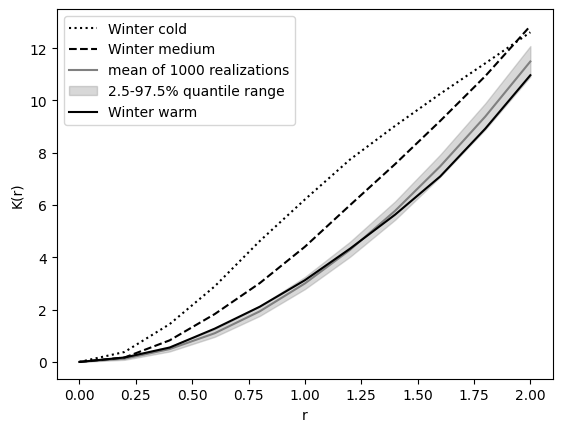

In [68]:
plot_envelope(
    k_winter_cold,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Winter cold",
    linestyle=":",
    show=False,
)
plot_envelope(
    k_winter_medium,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Winter medium",
    linestyle="--",
    show=False,
)

plot_envelope(
    k_winter_warm,
    ks_multiple,
    radii=k_radii,
    metric="K(r)",
    label="Winter warm",
    show=True,
)